In [18]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np


[*********************100%***********************]  3 of 3 completed

Ticker            AAPL       GOOGL        MSFT
Date                                          
2024-01-02  183.731308  137.133835  365.421600
2024-01-03  182.355591  137.878220  365.155609
2024-01-04  180.039658  135.367218  362.534607
2024-01-05  179.317169  134.712143  362.347473
2024-01-08  183.652130  137.798813  369.185516


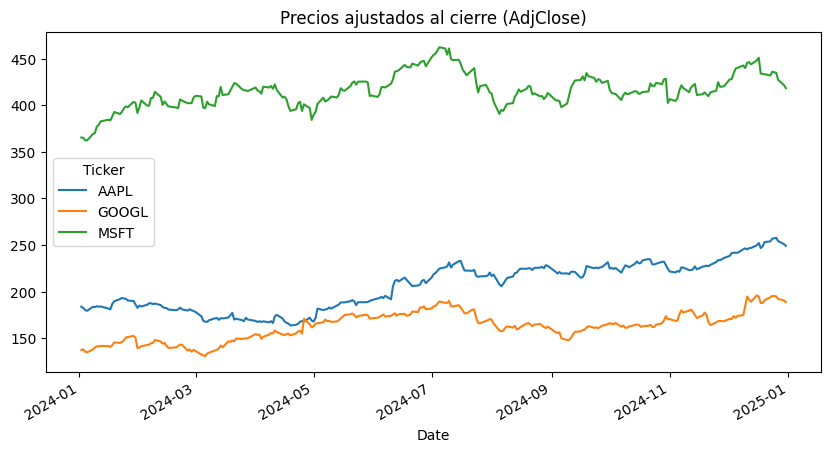

In [19]:
tickers = ['GOOGL','AAPL', 'MSFT']

data = yf.download(tickers, start='2024-01-01', end='2025-01-01', auto_adjust=True)['Close']
print(data.head())

data.plot(figsize=(10,5))
plt.title('Precios ajustados al cierre (AdjClose)')
plt.show()

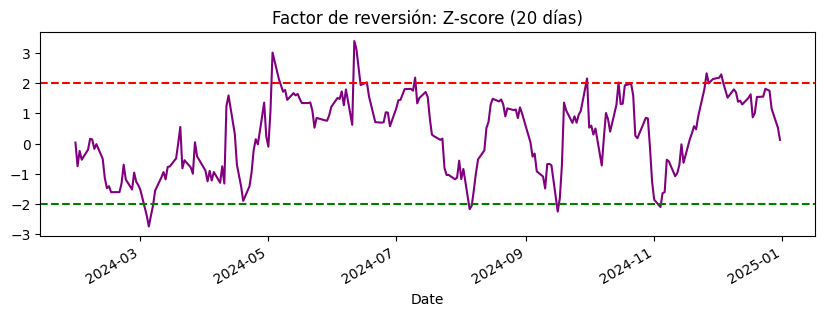

In [20]:
apple = data['AAPL'].to_frame()

window = 20
apple['Mean_20d'] =  apple['AAPL'].rolling(window=window).mean()
apple['Std_20d'] =  apple['AAPL'].rolling(window=window).std()

apple['Z_score'] = (apple['AAPL'] - apple['Mean_20d']) / apple['Std_20d']

plt.figure(figsize=(10,3))
apple['Z_score'].plot(color='purple')
plt.axhline(2, color='r', linestyle='--') #sobrecompra
plt.axhline(-2, color='g', linestyle='--') #sobreventa
plt.title('Factor de reversión: Z-score (20 días)')
plt.show()

In [21]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

apple['Target'] = (apple['AAPL'].shift(-1) > apple['AAPL']).astype(int)
apple = apple.dropna()

X = apple['Z_score'] #Feature
y = apple['Target']  #Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
model.fit(X_train, y_train)

print('Importancia de caracterísiticas:', model.feature_importances_)

Importancia de caracterísiticas: [1.]


c:\Users\Usuario\Desktop\Code\bachelor-thesis\venv\Lib\site-packages\shap\plots\_beeswarm.py:347: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  feature_names_new.append(feature_names[inds[0]])
c:\Users\Usuario\Desktop\Code\bachelor-thesis\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1406: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


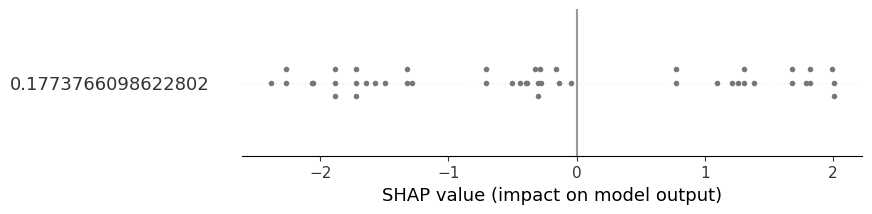

In [22]:
import shap

shap.initjs()

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Realizar predicciones con los datos que el modelo NO ha visto (X_test)
y_pred = model.predict(X_test)

# 1. Precisión simple (Accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2%}")

# 2. Informe detallado (Precision, Recall, F1-Score)
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred))

Precisión del modelo: 48.94%

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.38      0.50      0.43        18
           1       0.61      0.48      0.54        29

    accuracy                           0.49        47
   macro avg       0.49      0.49      0.48        47
weighted avg       0.52      0.49      0.50        47



In [ ]:
# cálculo del Z-Score sea sólido
window = 20
apple = data['AAPL'].to_frame()
apple.columns = ['Close']

# indicadores
apple['Mean'] = apple['Close'].rolling(window=window).mean()
apple['Std'] = apple['Close'].rolling(window=window).std()
apple['Z_Score'] = (apple['Close'] - apple['Mean']) / apple['Std']

#Target: mañana sube = 1, mañana baja = 0
apple['Target'] = (apple['Close'].shift(-1) > apple['Close']).astype(int)

apple = apple.dropna()

# X (Features) , y (Target)
X = apple[['Z_Score']]
y = apple['Target']

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#(80% entrenamiento, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

modelos = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True)
}

print(f"{'Modelo':<25} | {'Precisión (Test)':<20}")
print("-" * 50)

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{nombre:<25} | {acc:.2%}")

Modelo                    | Precisión (Test)    
--------------------------------------------------
Logistic Regression       | 61.70%
Random Forest             | 38.30%
SVM                       | 61.70%


In [26]:
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    
    acc_train = accuracy_score(y_train, modelo.predict(X_train))
    acc_test = accuracy_score(y_test, modelo.predict(X_test))
    
    print(f"{nombre}:")
    print(f"  - Precisión Train: {acc_train:.2%}")
    print(f"  - Precisión Test:  {acc_test:.2%}")
    print(f"  - Diferencia:      {abs(acc_train - acc_test):.2%}\n")

Logistic Regression:
  - Precisión Train: 56.99%
  - Precisión Test:  61.70%
  - Diferencia:      4.71%

Random Forest:
  - Precisión Train: 100.00%
  - Precisión Test:  38.30%
  - Diferencia:      61.70%

SVM:
  - Precisión Train: 57.53%
  - Precisión Test:  61.70%
  - Diferencia:      4.18%



In [34]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
modelo_final = LogisticRegression() # Aqui elegimos el modelo

print("Validación Cruzada Temporal (Logistic Regression):")
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_tr, X_te = X.iloc[train_index], X.iloc[test_index]
    y_tr, y_te = y.iloc[train_index], y.iloc[test_index]
    
    modelo_final.fit(X_tr, y_tr)
    score = accuracy_score(y_te, modelo_final.predict(X_te))
    print(f"Ventana {i+1}: Precisión = {score:.2%}")

Validación Cruzada Temporal (Logistic Regression):
Ventana 1: Precisión = 36.84%
Ventana 2: Precisión = 71.05%
Ventana 3: Precisión = 42.11%
Ventana 4: Precisión = 50.00%
Ventana 5: Precisión = 65.79%
